<a href="https://colab.research.google.com/github/IzaakGagnon/SSC2025_Data_Analysis_Competiton-Topological_Approach_to_Identifying_Hypoxic_Regions/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and Installs

In [1]:
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install tables
!pip install xgboost


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random
import os
import shutil
import xgboost as xgb
import networkx as nx
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from itertools import combinations, product
from joblib import Parallel, delayed


Load Data and Create Training/Testing Split

In [2]:
random.seed(30)
np.random.seed(30)

# As needed
from google.colab import drive
drive.mount('/content/drive')


# Tell python which folder to look in. Change depending on the bin dimension
dim_bins = 100

relative_path = f"/dim_bins{dim_bins}/"

# Function to the h5 file at the chosen path
def read_h5(file_path):
    if file_path.endswith(".h5"):
      df = pd.read_hdf(file_path)
      print("File successfully read.\n")
      return df
    else:
      print("File is not an h5. Skipping...\n")

# Optional: Submit the raw folder path in your own drive
folder_path = f"/content/drive/MyDrive/dim_bins50"

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(file_names)
def split_files(file_names, num_training):
    # Randomly select 'num_in_list1' files
    training_split = random.sample(file_names, num_training)
    # The remaining files
    testing_split = [f for f in file_names if f not in training_split]
    return training_split, testing_split
print(len(file_names))
testing_amount = 16
num_training = len(file_names) - testing_amount
print(num_training)  # 12 testing files, rest for training + eval
training_split, testing_split = split_files(file_names, num_training)

print("Training Split:", training_split)
print("Testing Split:", testing_split)

training_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in training_split]
testing_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in testing_split]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['component_19_binned_5641.h5', 'component_32_binned_7828.h5', 'component_12_binned_6936.h5', 'component_29_binned_7252.h5', 'component_20_binned_12556.h5', 'component_23_binned_6397.h5', 'component_28_binned_6517.h5', 'component_18_binned_5127.h5', 'component_30_binned_6746.h5', 'component_31_binned_4006.h5', 'component_27_binned_6032.h5', 'component_22_binned_6090.h5', 'component_26_binned_5265.h5', 'component_16_binned_7076.h5', 'component_25_binned_4878.h5', 'component_24_binned_7926.h5', 'component_6_binned_13296.h5', 'component_11_binned_6741.h5', 'component_9_binned_11350.h5', 'component_13_binned_8869.h5', 'component_1_binned_12968.h5', 'component_4_binned_5289.h5', 'component_21_binned_10418.h5', 'component_7_binned_8147.h5', 'component_3_binned_7318.h5', 'component_15_binned_10159.h5', 'component_5_binned_10452.h5', 'component_0_binned_8752.h5', 'co

Created 252 custom CV splits.
Saved train_test_fold_1.png


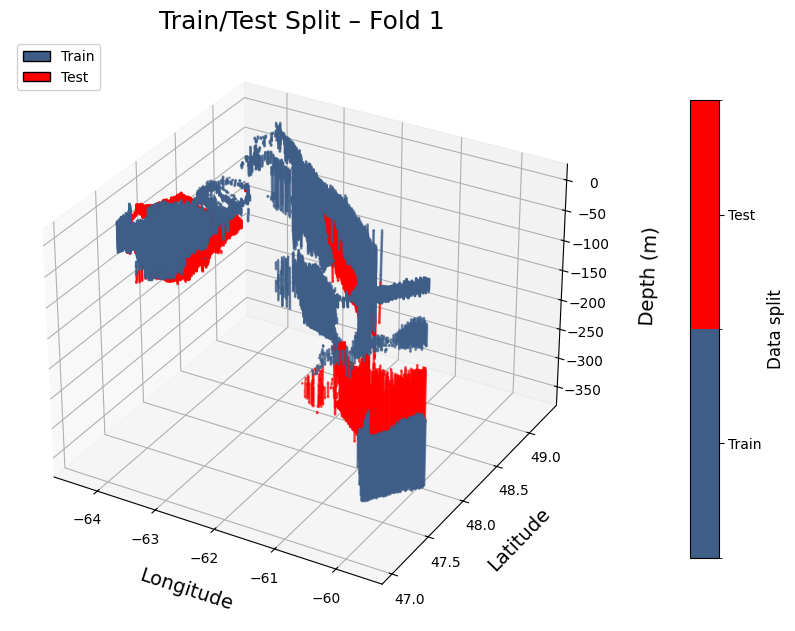

Saved train_test_fold_2.png


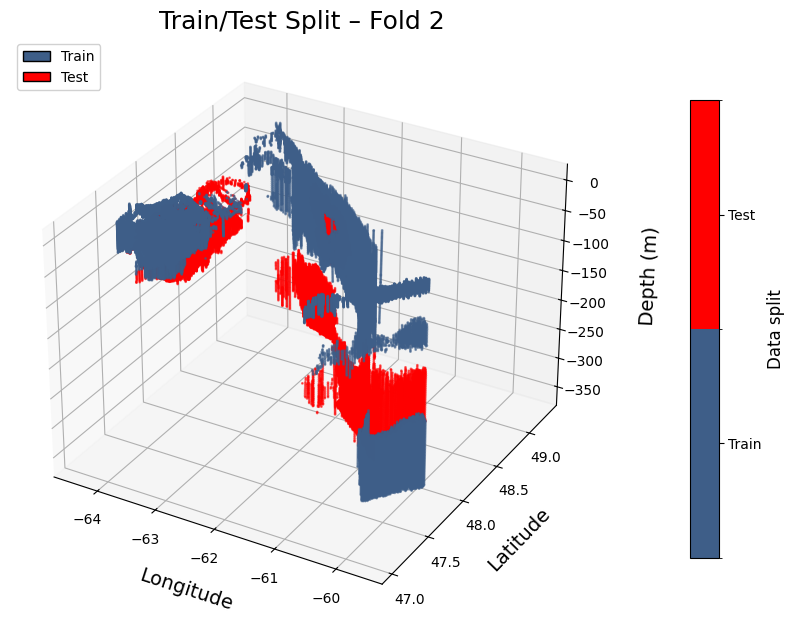

Saved train_test_fold_3.png


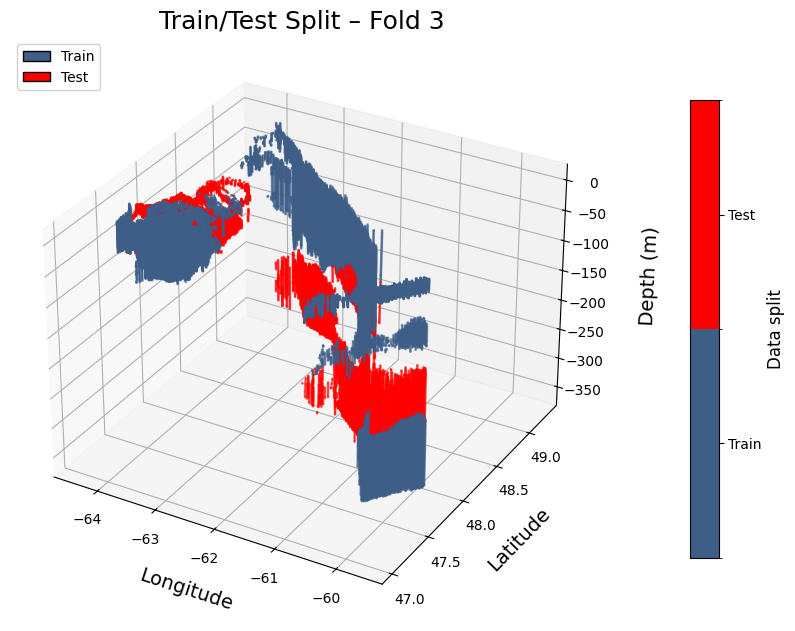

Saved train_test_fold_4.png


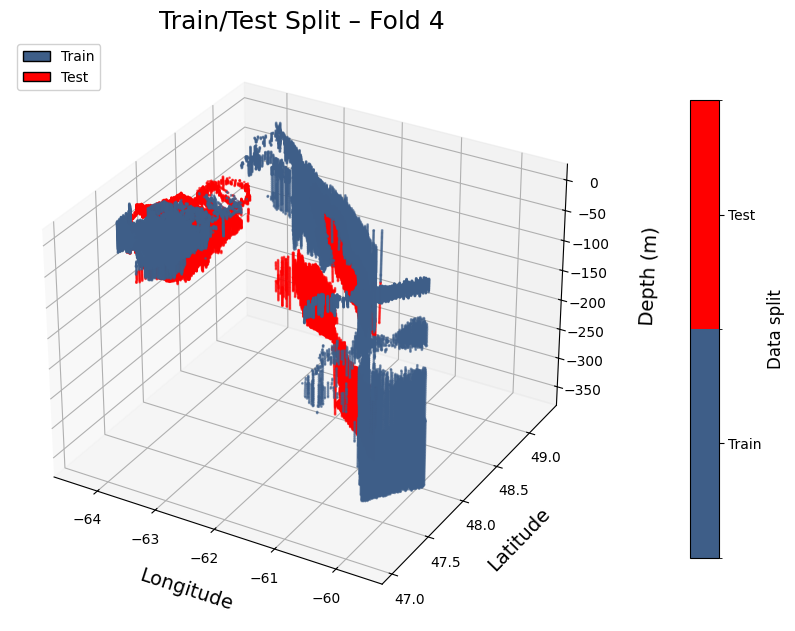

Saved train_test_fold_5.png


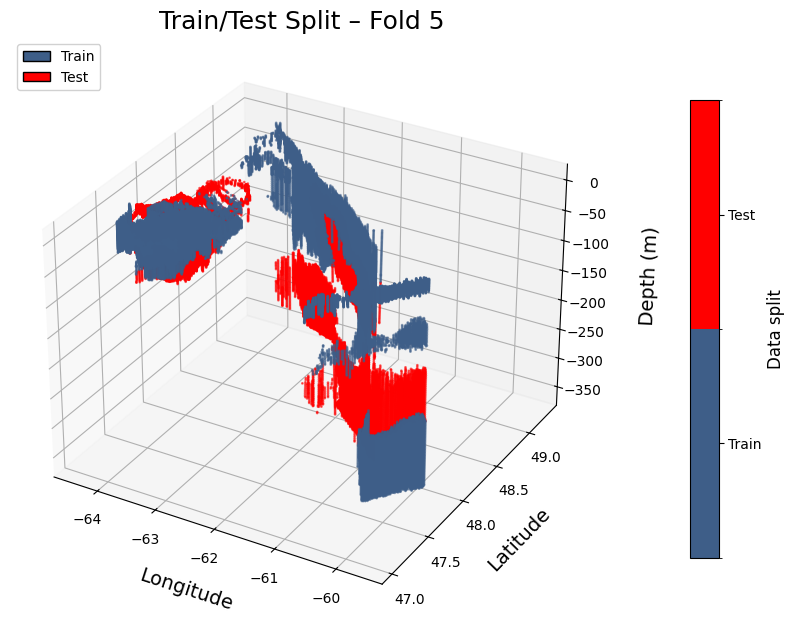

Saved train_test_fold_6.png


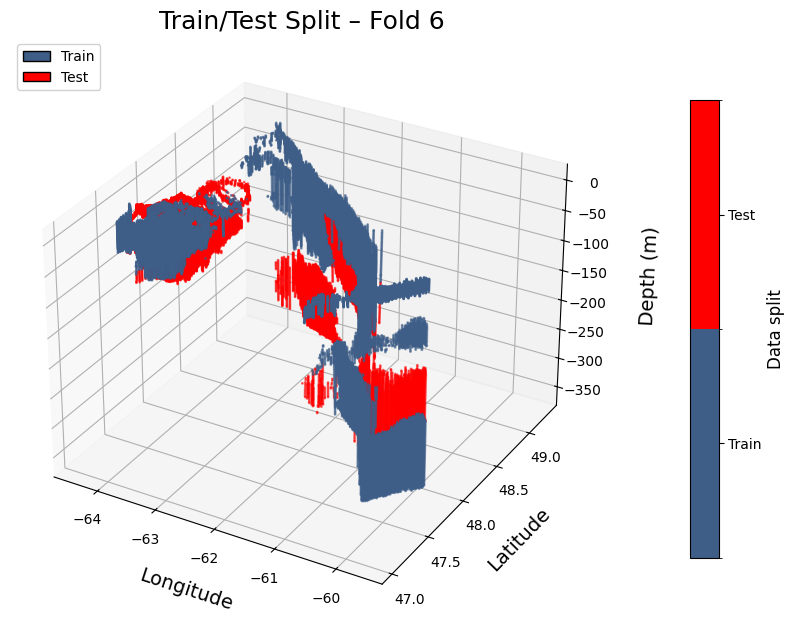

Saved train_test_fold_7.png


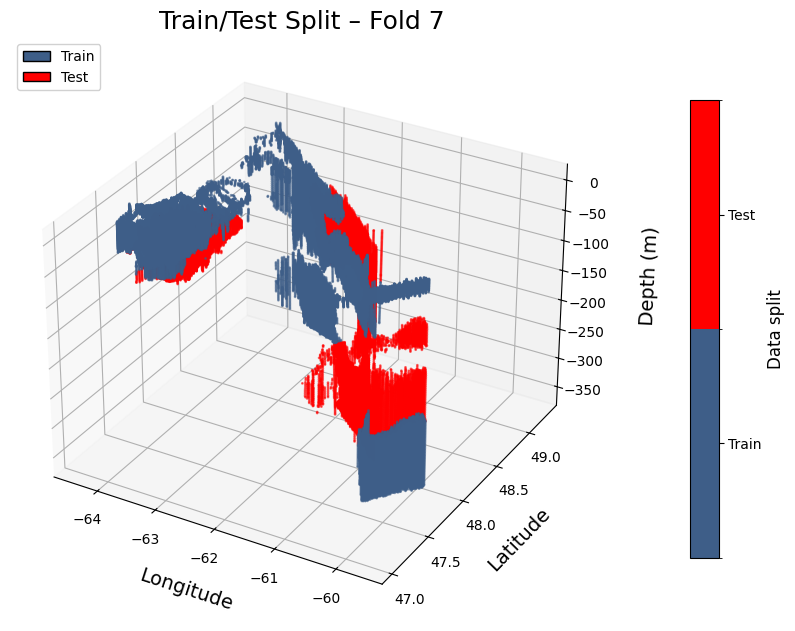

Saved train_test_fold_8.png


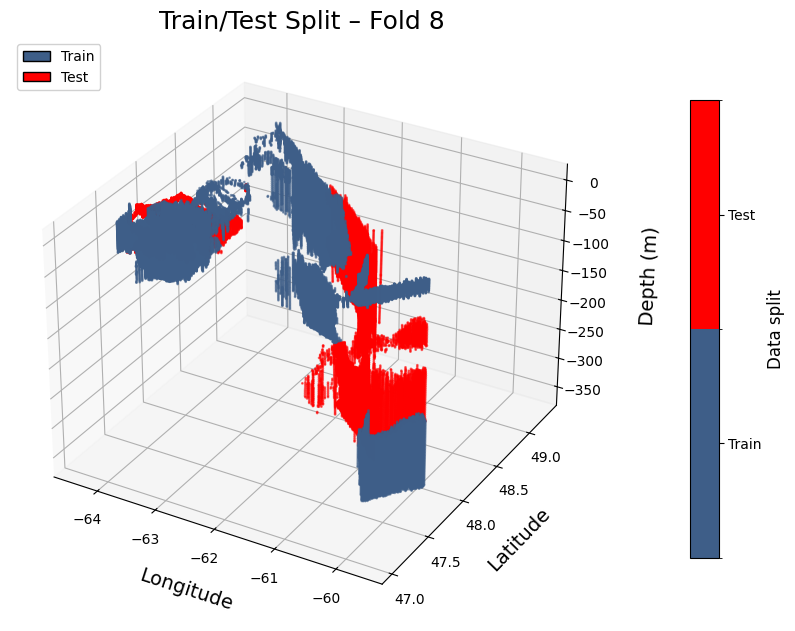

Saved train_test_fold_9.png


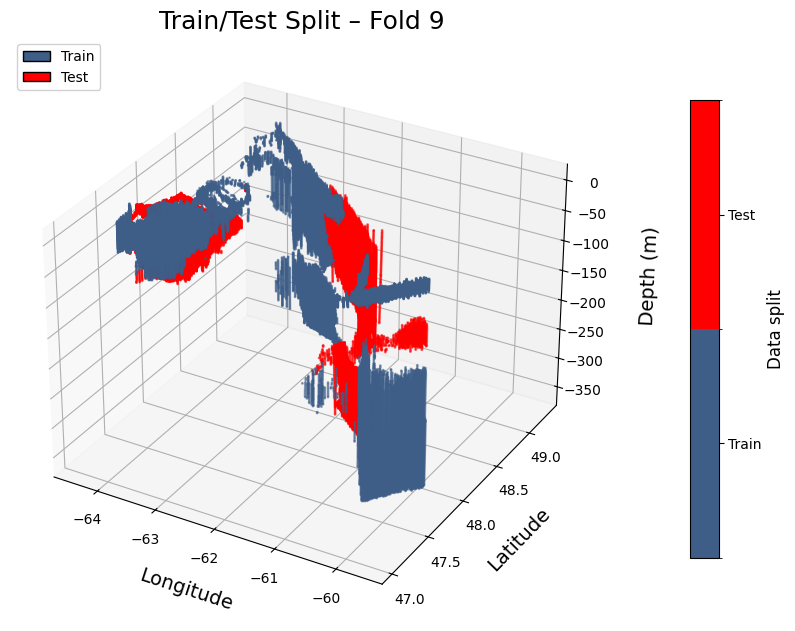

Saved train_test_fold_10.png


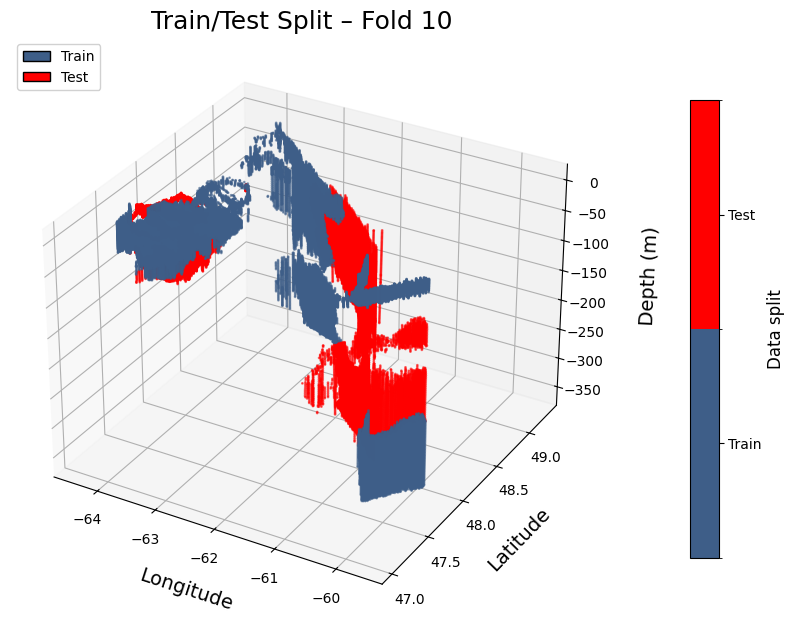

In [3]:
# ==============================================================
#  Custom 5‑of‑10‑fold CV + 3‑D Train/Test Visualiser
# ==============================================================



k                 = 10   # total folds taken from the 16 datasets not set aside for testing
train_folds_count = 5    # folds used for training -> k - % for validation
rng_seed          = 42   #
max_plots         = 10   # how many splits to visualise

# Assign datasets to k folds
n_datasets  = len(training_datasets)
kf          = KFold(n_splits=k, shuffle=True, random_state=rng_seed)
dataset_idx = np.arange(n_datasets)
folds = [[] for _ in range(k)]
for fold_i, (_, test_idx) in enumerate(kf.split(dataset_idx)):
    for j in test_idx:
        folds[fold_i].append(j)

# Build every (5 train, 5 test) combination
train_combos = list(combinations(range(k), train_folds_count))
custom_folds = []
for combo in train_combos:
    test_combo    = [f for f in range(k) if f not in combo]
    train_indices = [idx for f in combo      for idx in folds[f]]
    test_indices  = [idx for f in test_combo for idx in folds[f]]
    train_df = pd.concat([training_datasets[i] for i in train_indices],
                         ignore_index=True)
    test_df  = pd.concat([training_datasets[i] for i in test_indices],
                         ignore_index=True)
    custom_folds.append((train_df, test_df))

print(f"Created {len(custom_folds)} custom CV splits.")



# Visualise 10 of such
train_color = "#3e5e88"
test_color  = "red"
cmap        = ListedColormap([train_color, test_color])
norm        = BoundaryNorm([0, 1, 2], cmap.N)

for i, (train_df, test_df) in enumerate(custom_folds[:max_plots], start=1):
    fig = plt.figure(figsize=(10, 8))
    ax  = fig.add_subplot(111, projection="3d")

    # --- scatter points -------------------------------------
    ax.scatter(train_df["longitude"], train_df["latitude"], -train_df["depth"],
               c=train_color, alpha=0.55, s=1.0)
    ax.scatter(test_df["longitude"],  test_df["latitude"],  -test_df["depth"],
               c=test_color,  alpha=0.55, s=1.0)

    # --- axis labels ----------------------------------------
    ax.set_xlabel("Longitude", fontsize=14, labelpad=10)
    ax.set_ylabel("Latitude",  fontsize=14, labelpad=10)
    ax.set_zlabel("Depth (m)", fontsize=14, labelpad=18)

    # --- categorical colour‑bar -----------------------------
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.12, shrink=0.65,
                        ticks=[0.5, 1.5], aspect=16)
    cbar.ax.set_yticklabels(["Train", "Test"])
    cbar.set_label("Data split", fontsize=12)

    # --- legend
    legend_handles = [
        Patch(facecolor=train_color, edgecolor="black", label="Train"),
        Patch(facecolor=test_color,  edgecolor="black", label="Test")
    ]
    ax.legend(handles=legend_handles, loc="upper left",
              frameon=True, framealpha=0.9)

    # title
    ax.set_title(f"Train/Test Split – Fold {i}", fontsize=18)
    fig.subplots_adjust(left=0.05, right=0.85, bottom=0.05, top=0.93)

    fname = f"train_test_fold_{i}.png"
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    print(f"Saved {fname}")
    plt.show()


Train an Elastic-Net Model

In [4]:

# Define our predictors and target
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Hyperparameter grid search
param_grid = {
    'alpha': np.logspace(-3, 3, 10),       # penalty term
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, .7, 0.8, 0.9, 1]    # elasticnet mixing parameter
}
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
print(f"Total combinations of parameters to try: {len(param_combinations)}")


fold_count = 10  # Number of folds used - Ensure this is same as generated in previous block

# Define a function to evaluate one combination of hyperparameters
def evaluate_params(params):
    mse_scores = []
    r2_scores = []

    # Loop over each fold
    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = ElasticNet(alpha=params['alpha'],
                           l1_ratio=params['l1_ratio'],
                           random_state=30)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"Fold R²: {r2}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Params: {params} → Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")
    return (params, avg_mse, avg_r2)

# Evaluate all hyperparameter combinations in parallel
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(dict(zip(param_names, combo)))
    for combo in param_combinations
)

# Find best parameter set (using smallest MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Train final model on the full training data and evaluate on unseen test data
train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

final_model = ElasticNet(alpha=best_params['alpha'],
                         l1_ratio=best_params['l1_ratio'],
                         random_state=30)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"R² for Final Model: {final_r2}")
print(f"MSE for Final Model: {final_mse}")


Total combinations of parameters to try: 110

===== Best Hyperparameters =====
Best Params: {'alpha': np.float64(0.46415888336127775), 'l1_ratio': 0.8}
Avg MSE: 719.6812
Avg R²: 0.8744
Best RMSE: 26.8269
R² for Final Model: 0.8996245265007019
MSE for Final Model: 611.5974731445312


Train an XGBoost Model

In [5]:
# Define features and target
target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define hyperparameter grid for grid search
# key parameters which are commented out are such used in our model, however feel free to change as needed
param_grid = {
    #'n_estimators': [100],
    'learning_rate': np.linspace(0.01, 0.5, 100),
    'max_depth': [i for i in range(3, 9)],
    #'subsample': [0.8],
    #'colsample_bytree': [0.8]
}
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
print(f"Total combinations of parameters to try: {len(param_combinations)}")


fold_count = 10  # number of folds to use from custom_folds, see elasticnet block for how to decide this value

# Evaluate a model defined by certain parameters
def evaluate_params(params, folds):
    mse_scores = []
    r2_scores = []
    for train_df, test_df in folds:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
        print(f"R² for current fold: {r2_scores[-1]} with {len(folds)} folds")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f"Evaluated params {params}: Avg MSE = {avg_mse:.4f} | Avg R² = {avg_r2:.4f}")
    return (params, avg_mse, avg_r2)

# Parallelize evaluation over all parameter combinations
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(
        dict(zip(param_names, combo)),
        custom_folds[:fold_count]
    )
    for combo in param_combinations
)

# Find best param set (using smallest average MSE)
best_result = min(results, key=lambda x: x[1])
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Train final model on the full training data and evaluate on unseen test data
train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

final_model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    verbosity=0
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"R² for Final Model: {final_r2}")
print(f"MSE for Final Model: {final_mse}")

Total combinations of parameters to try: 600

===== Best Hyperparameters =====
Best Params: {'learning_rate': np.float64(0.16838383838383839), 'max_depth': 3}
Avg MSE: 480.0523
Avg R²: 0.9145
Best RMSE: 21.9101
R² for Final Model: 0.9566681385040283
MSE for Final Model: 264.0252990722656


Random Forest Model

In [6]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Replace with the actual column name of your target
target_col = 'oxygen'  # example

mse_rf_scores = []
r2_rf_scores = []

for i, (train_df, test_df) in enumerate( custom_folds[:fold_count]):
    X_train = train_df.drop(columns=[target_col,'voxel'])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col,'voxel'])
    y_test = test_df[target_col]

    # Define and train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_rf_scores.append(mse)
    r2_rf_scores.append(r2)

    print(f"[RF] Fold {i+1:03d} | MSE: {mse:.4f} | R²: {r2:.4f}")

# Final summary
print("\n===== Random Forest CV Results =====")
print(f"Average MSE: {np.mean(mse_rf_scores):.4f} ± {1.96*np.std(mse_rf_scores):.4f}")
print(f"Average R²: {np.mean(r2_rf_scores):.4f} ± {1.96*np.std(r2_rf_scores):.4f}")


[RF] Fold 001 | MSE: 685.2015 | R²: 0.8614
[RF] Fold 002 | MSE: 456.3788 | R²: 0.9413
[RF] Fold 003 | MSE: 525.8571 | R²: 0.9216
[RF] Fold 004 | MSE: 643.5226 | R²: 0.8927
[RF] Fold 005 | MSE: 454.9514 | R²: 0.9271
[RF] Fold 006 | MSE: 681.2230 | R²: 0.8711
[RF] Fold 007 | MSE: 444.2403 | R²: 0.9278
[RF] Fold 008 | MSE: 952.4060 | R²: 0.8300
[RF] Fold 009 | MSE: 864.1548 | R²: 0.7872
[RF] Fold 010 | MSE: 719.2211 | R²: 0.8581

===== Random Forest CV Results =====
Average MSE: 642.7157 ± 326.2739
Average R²: 0.8818 ± 0.0922


Plot our Precitions vs Measured Thresholds by Color (Two Color Schemes)
(latter used in poster)

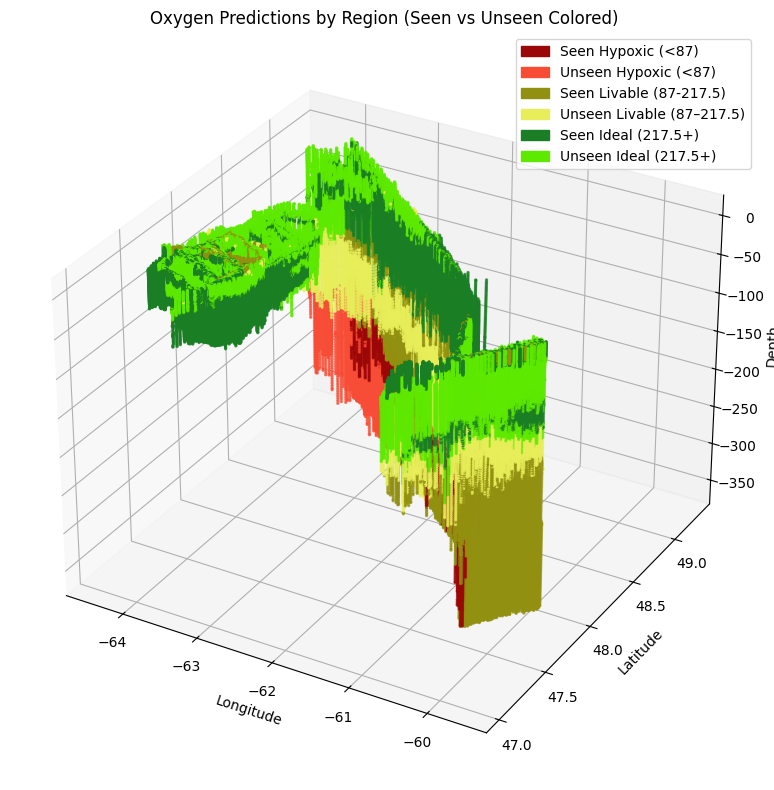

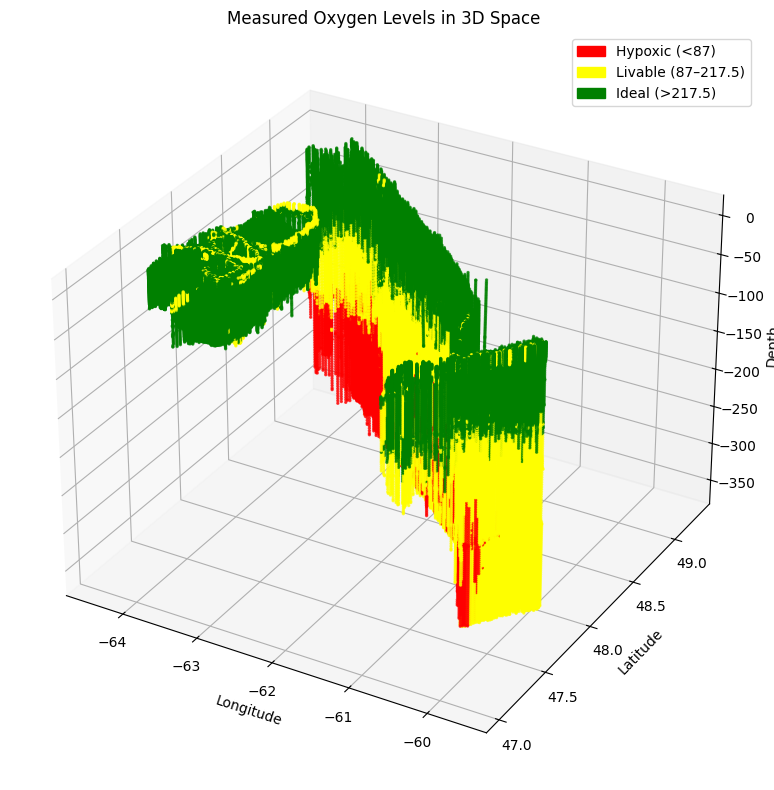

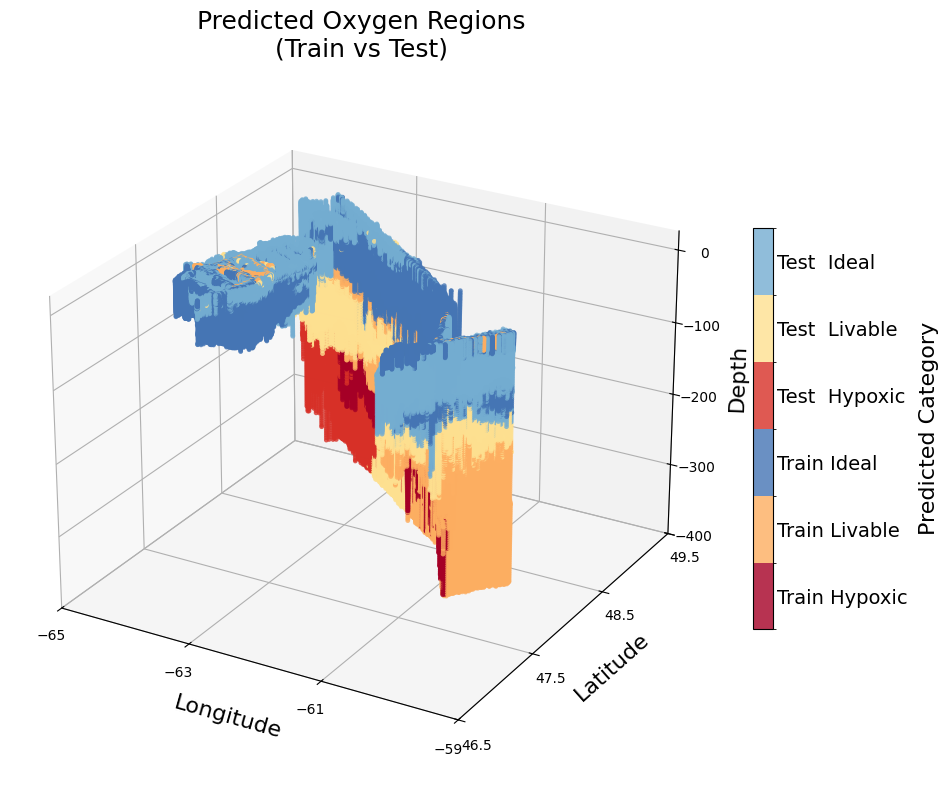

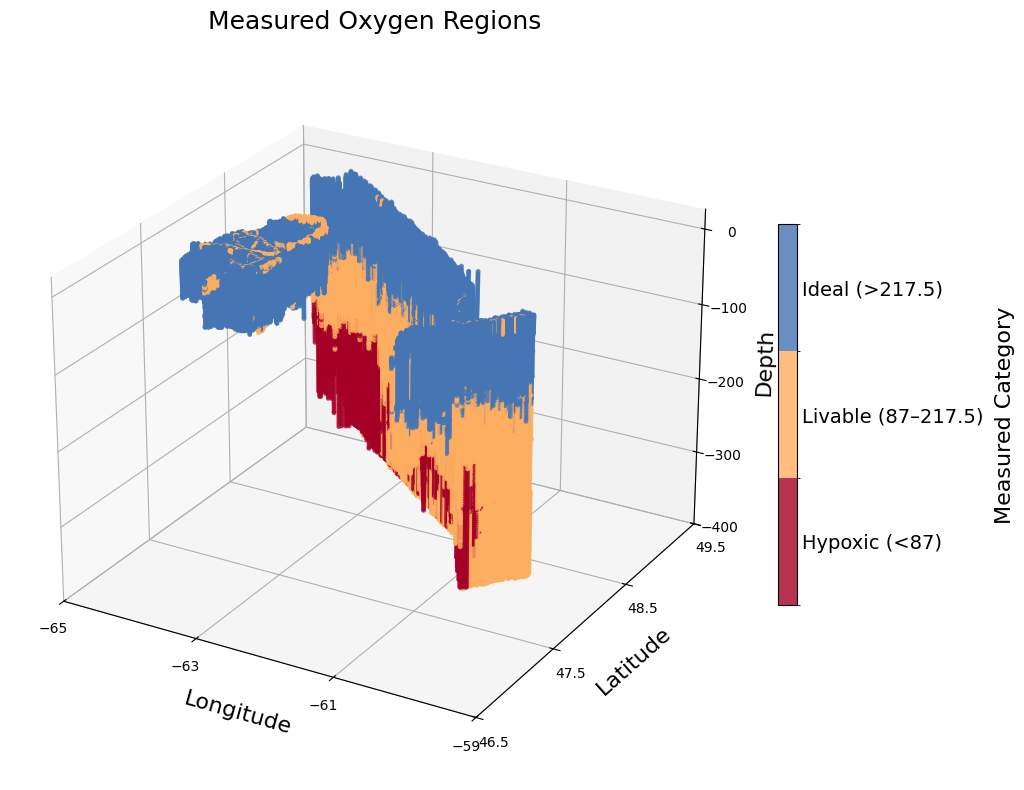

In [7]:
# Region plots on predicted data
import matplotlib.patches as mpatches

# === Label each row as 'train' or 'test' ===
for df in training_datasets:
    df["source"] = "train"
for df in testing_datasets:
    df["source"] = "test"

# Combine all into one full dataset
full_df = pd.concat(training_datasets + testing_datasets, ignore_index=True)

# Prepare features/target
X_full = full_df.drop(columns=[target, 'voxel', 'source'])
y_full = full_df[target]

# Train the model again, (not a long process) using the ideal parameters found previously
final_model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    verbosity=0
)
final_model.fit(X_full, y_full)

# Predict
y_pred = final_model.predict(X_full)
full_df = full_df.copy()
full_df["oxygen_pred"] = y_pred

# === Color Mapping Based on Prediction and Source ===
def get_color(row):
    oxygen = row["oxygen_pred"]
    source = row["source"]

    if oxygen < 87:
        return '#9b0707' if source == "train" else '#f84c35'  # Hypoxic - Red
    elif oxygen < 217.5:
        return '#929010' if source == "train" else '#e7ee5a'  # Livable - Yellow
    else:
        return '#1a7f24' if source == "train" else '#5ee900'  # Ideal - Green
full_df["color"] = full_df.apply(get_color, axis=1)

# === 3D Scatter Plot ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    full_df['longitude'],
    full_df['latitude'],
    -full_df['depth'],
    c=full_df['color'],
    s=2,
    alpha=0.7
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth")
ax.set_title("Oxygen Predictions by Region (Seen vs Unseen Colored)")

# Legend
legend_elements = [
    mpatches.Patch(color='#9b0707', label='Seen Hypoxic (<87)'), # dark red
    mpatches.Patch(color='#f84c35', label='Unseen Hypoxic (<87)'), # light red
    mpatches.Patch(color='#929010', label='Seen Livable (87-217.5)'), # dark yellow
    mpatches.Patch(color='#e7ee5a', label='Unseen Livable (87–217.5)'), # light yellow
    mpatches.Patch(color='#1a7f24', label='Seen Ideal (217.5+)'), # dark green
    mpatches.Patch(color='#5ee900', label='Unseen Ideal (217.5+)') # light green
]
ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()





###############################################################################

# Region plot on all data

###############################################################################
# === Color Mapping Based Only on Oxygen Levels ===
def get_color_from_truth(oxygen):
    if oxygen < 87:
        return 'red'
    elif oxygen < 217.5:
        return 'yellow'
    else:
        return 'green'

full_df["color"] = full_df["oxygen"].apply(get_color_from_truth)

# === 3D Scatter Plot of True Oxygen ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    full_df['longitude'],
    full_df['latitude'],
    -full_df['depth'],
    c=full_df['color'],
    s=2,
    alpha=0.7
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth")
ax.set_title("Measured Oxygen Levels in 3D Space")

# Legend for true oxygen categories
legend_elements = [
    mpatches.Patch(color='red', label='Hypoxic (<87)'), # red
    mpatches.Patch(color='yellow', label='Livable (87–217.5)'), # yellow
    mpatches.Patch(color='green', label='Ideal (>217.5)') # green
]
ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# Second Style (With Improved Readability)

base_fs = plt.rcParams['font.size']
new_fs = base_fs * 1.5
# ——— Helper to clean up 3D axes ———
def style_axes(ax, title):
    ax.set_title(title, pad=15, fontsize=18)
    ax.set_xlabel("Longitude", labelpad=8,fontsize=16)
    ax.set_ylabel("Latitude",  labelpad=8,fontsize=16)
    ax.set_zlabel("Depth",     labelpad=8,fontsize=16)
    ax.view_init(elev=25, azim=-60)
    ax.grid(True)
    for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
        pane.set_edgecolor('none')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_zticks(ax.get_zticks()[::2])

# ——— Prepare predicted‐oxygen categories (0–5) ———
pal_train = ['#a50026', '#fdae61', '#4575b4']
pal_test  = ['#d73027', '#fee090', '#74add1']

def pred_cat_idx(row):
    if row.oxygen_pred < 87:
        ci = 0
    elif row.oxygen_pred < 217.5:
        ci = 1
    else:
        ci = 2
    return ci if row.source=='train' else ci+3

full_df['cat_idx'] = full_df.apply(pred_cat_idx, axis=1)

cmap_pred = ListedColormap(pal_train + pal_test)
norm_pred = BoundaryNorm(np.arange(-0.5, 6.5), cmap_pred.N)

# ——— Plot 1: Predicted Oxygen Regions ———
fig = plt.figure(figsize=(12,8), facecolor='white')
ax  = fig.add_subplot(111, projection='3d')
sc1 = ax.scatter(
    full_df['longitude'],
    full_df['latitude'],
    -full_df['depth'],
    c=full_df['cat_idx'],
    cmap=cmap_pred,
    norm=norm_pred,
    s=12, alpha=0.8, linewidth=0
)
style_axes(ax, "Predicted Oxygen Regions\n(Train vs Test)")
cbar1 = plt.colorbar(sc1, ticks=np.arange(6), fraction=0.02, pad=0.04)
cbar1.ax.set_yticklabels([
    'Train Hypoxic', 'Train Livable', 'Train Ideal',
    'Test  Hypoxic', 'Test  Livable', 'Test  Ideal'
], fontsize = 14)
cbar1.ax.tick_params(length=0)
cbar1.set_label("Predicted Category", labelpad=8, fontsize = 16)
plt.tight_layout()
plt.show()

# ——— Prepare true‐oxygen categories (0–2) ———
pal_true = ['#a50026', '#fdae61', '#4575b4']
cmap_true = ListedColormap(pal_true)
norm_true = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap_true.N)

full_df['true_idx'] = full_df['oxygen'].apply(
    lambda o: 0 if o < 87 else 1 if o < 217.5 else 2
)

# ——— Plot 2: Measured Oxygen Regions ———
fig = plt.figure(figsize=(12,8), facecolor='white')
ax  = fig.add_subplot(111, projection='3d')
sc2 = ax.scatter(
    full_df['longitude'],
    full_df['latitude'],
    -full_df['depth'],
    c=full_df['true_idx'],
    cmap=cmap_true,
    norm=norm_true,
    s=12, alpha=0.8, linewidth=0
)
style_axes(ax, "Measured Oxygen Regions")
cbar2 = plt.colorbar(sc2, ticks=[0,1,2], fraction=0.02, pad=0.04)
cbar2.ax.set_yticklabels(['Hypoxic (<87)', 'Livable (87–217.5)', 'Ideal (>217.5)'], fontsize = 14)
cbar2.ax.tick_params(length=0)
cbar2.set_label("Measured Category", labelpad=8, fontsize = 16)
plt.tight_layout()
plt.show()

Combine the Two Plots onto the same figure (Optional)

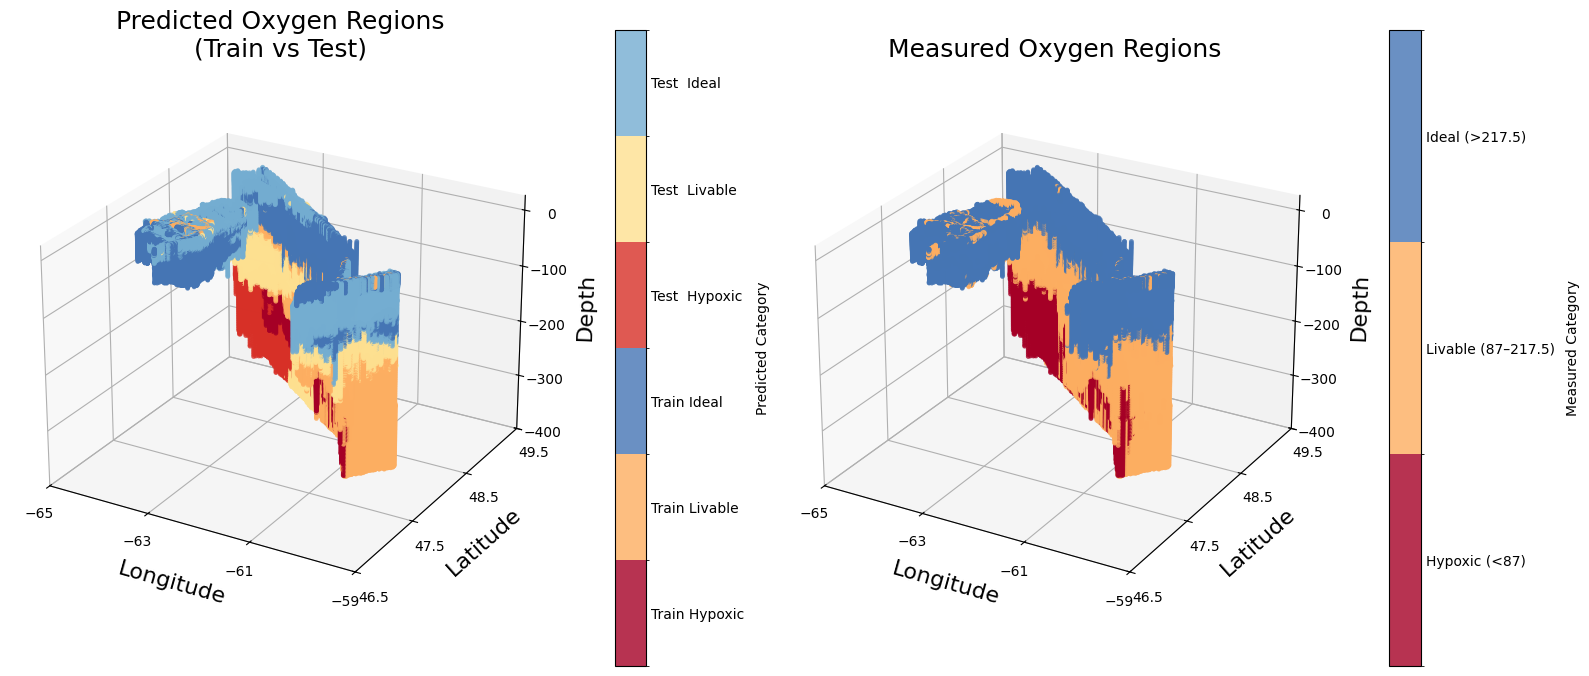

In [8]:


# ——— Helper to clean up 3D axes ———
def style_axes(ax, title):
    ax.set_title(title, pad=15, fontsize=18)
    ax.set_xlabel("Longitude", labelpad=8, fontsize =  16)
    ax.set_ylabel("Latitude",  labelpad=8, fontsize = 16)
    ax.set_zlabel("Depth",     labelpad=8, fontsize = 16)
    ax.view_init(elev=25, azim=-60)
    ax.grid(True)
    for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
        pane.set_edgecolor('none')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yticks(ax.get_yticks()[::2])
    ax.set_zticks(ax.get_zticks()[::2])

# ——— Build category indices & colormaps ———
# Predicted: six categories (train/test × hypoxic/livable/ideal)
pal_train = ['#a50026', '#fdae61', '#4575b4']
pal_test  = ['#d73027', '#fee090', '#74add1']
cmap_pred = ListedColormap(pal_train + pal_test)
norm_pred = BoundaryNorm(np.arange(-0.5, 6.5), cmap_pred.N)

def pred_cat_idx(row):
    if   row.oxygen_pred < 87:    ci = 0
    elif row.oxygen_pred < 217.5: ci = 1
    else:                         ci = 2
    return ci if row.source=='train' else ci+3

full_df['cat_idx'] = full_df.apply(pred_cat_idx, axis=1)

# Measured: three categories
pal_true = ['#a50026', '#fdae61', '#4575b4']
cmap_true = ListedColormap(pal_true)
norm_true = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap_true.N)

full_df['true_idx'] = full_df['oxygen'].apply(
    lambda o: 0 if o<87 else 1 if o<217.5 else 2
)

# ——— Create subplots ———
fig = plt.figure(figsize=(16, 8), facecolor='white')
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# — Predicted Oxygen Regions ——
sc1 = ax1.scatter(
    full_df['longitude'], full_df['latitude'], -full_df['depth'],
    c=full_df['cat_idx'], cmap=cmap_pred, norm=norm_pred,
    s=12, alpha=0.8, linewidth=0
)
style_axes(ax1, "Predicted Oxygen Regions\n(Train vs Test)")
cbar1 = fig.colorbar(sc1, ax=ax1, ticks=np.arange(6), fraction=0.05, pad=0.1)
cbar1.ax.set_yticklabels([
    'Train Hypoxic', 'Train Livable', 'Train Ideal',
    'Test  Hypoxic',  'Test  Livable',  'Test  Ideal'
])
cbar1.ax.tick_params(length=0)
cbar1.set_label("Predicted Category", labelpad=8)

# — Measured Oxygen Regions ——
sc2 = ax2.scatter(
    full_df['longitude'], full_df['latitude'], -full_df['depth'],
    c=full_df['true_idx'], cmap=cmap_true, norm=norm_true,
    s=12, alpha=0.8, linewidth=0
)
style_axes(ax2, "Measured Oxygen Regions")
cbar2 = fig.colorbar(sc2, ax=ax2, ticks=[0,1,2], fraction=0.05, pad=0.1)
cbar2.ax.set_yticklabels(['Hypoxic (<87)', 'Livable (87–217.5)', 'Ideal (>217.5)'])
cbar2.ax.tick_params(length=0)
cbar2.set_label("Measured Category", labelpad=8)

plt.tight_layout()
plt.show()
